# Import Necessary Libraries

In [62]:
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt

# Import data

### The data can be acquired [here](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength).

In [45]:
df = pd.read_excel("Concrete_Data.xls")

# Explore Data

In [46]:
# show first 10 rows
df.head(10)

,cement,slag,fly_ash,water,superplasiticizer,coarse_aggregates,fine_aggregate,age,compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.029847
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365,43.698299
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.447770
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.854291
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28,39.289790


In [47]:
# show size of data
df.shape

(1030, 9)

In [48]:
# show statistics of data
df.describe()

,cement,slag,fly_ash,water,superplasiticizer,coarse_aggregates,fine_aggregate,age,compressive_strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


In [49]:
# show information about samples
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cement                1030 non-null   float64
 1   slag                  1030 non-null   float64
 2   fly_ash               1030 non-null   float64
 3   water                 1030 non-null   float64
 4   superplasiticizer     1030 non-null   float64
 5   coarse_aggregates     1030 non-null   float64
 6   fine_aggregate        1030 non-null   float64
 7   age                   1030 non-null   int64  
 8   compressive_strength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [51]:
# check samples with missing data
df.isna().sum()

cement                  0
slag                    0
fly_ash                 0
water                   0
superplasiticizer       0
coarse_aggregates       0
fine_aggregate          0
age                     0
compressive_strength    0
dtype: int64

In [52]:
# check duplicates
df.duplicated().sum()

25

In [53]:
# drop duplicate data
df.drop_duplicates(inplace=True)

In [54]:
# check shape of data
df.shape

(1005, 9)

# Prepare data for training

In [55]:
# split features and target from the dataframe
X = df.drop("compressive_strength",axis=1)
y = df["compressive_strength"]

In [69]:
# scale the data using scikit learn StandardScaler
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
print(f"Peak to Peak range by column in Raw        X:{np.ptp(X,axis=0)}")   
print(f"Peak to Peak range by column in Normalized X:{np.ptp(X_norm,axis=0)}")

Peak to Peak range by column in Raw        X:cement               438.00
slag                 359.40
fly_ash              200.10
water                125.25
superplasiticizer     32.20
coarse_aggregates    344.00
fine_aggregate       398.60
age                  364.00
dtype: float64
Peak to Peak range by column in Normalized X:[4.1997035  4.17287482 3.1180125  5.87197829 5.44230269 4.43636686
 4.9638934  5.71401885]


In [70]:
# split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

# Define evaluation functions

In [71]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=10)).mean()
    return rmse

def evaluate(y, predictions):
    mae = mean_absolute_error(y, predictions)
    mse = mean_squared_error(y, predictions)
    r_squared = r2_score(y, predictions)
    return mae, mse, r_squared

In [105]:
models = pd.DataFrame(columns=["Model", "MAE", "MSE", "r2 Score", "RMSE (Cross Validated)"])

# Begin Machine Learning

### Use [stochastic gradient descent](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#examples-using-sklearn-linear-model-sgdregressor)

In [106]:
# Use stochastic gradient descent 
sgdr = SGDRegressor()
sgdr.fit(X_train, y_train)
predictions = sgdr.predict(X_test)

mae, mse, r2 = evaluate(y_test, predictions)
rmse = rmse_cv(lin_reg)
print("MAE:", mae)
print("MSE:", mse)
print("r2 Score:", r2)
print("RMSE (Cross Validated):", rmse)

new_row = {"Model": "SGDRegressor","MAE": mae, "MSE": mse, "r2 Score": r2, "RMSE (Cross Validated)": rmse}
models = models.append(new_row, ignore_index=True)

MAE: 8.919084282964999
MSE: 125.55132813192915
r2 Score: 0.5791502601558138
RMSE (Cross Validated): 10.935058378434722


C:\Users\User\AppData\Local\Temp\ipykernel_15636\1632050313.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(new_row, ignore_index=True)


#### Check the parameters.

In [76]:
b_norm = sgdr.intercept_
w_norm = sgdr.coef_
print(f"model parameters:                   w: {w_norm}, b:{b_norm}")

model parameters:                   w: [11.05492246  7.27714132  4.4411626  -3.79695836  1.7910742   0.33454882
  0.54671073  6.97160688], b:[35.06535966]


In [79]:
# make a prediction using sgdr.predict()
y_pred_sgd = sgdr.predict(X_train)
# make a prediction using w,b. 
y_pred = np.dot(X_train, w_norm) + b_norm  
print(f"prediction using np.dot() and sgdr.predict match: {(y_pred == y_pred_sgd).all()}")

print(f"Prediction on training set:\n{y_pred[:4]}" )
print(f"Target values \n{y_train[:4]}")

prediction using np.dot() and sgdr.predict match: True
Prediction on training set:
[61.40395242 30.29716118 33.2937704  30.69350783]
Target values 
79     41.299612
29     38.603761
304    23.138815
531    23.848975
Name: compressive_strength, dtype: float64


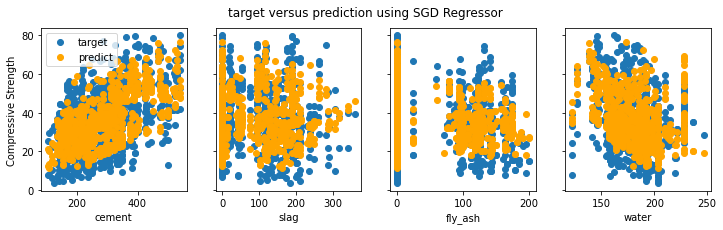

In [102]:
# plot predictions and targets vs original features
X_features = ['cement','slag','fly_ash','water']
X_train_tr = scaler.inverse_transform(X_train)
fig,ax=plt.subplots(1,4,figsize=(12,3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train_tr[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(X_train_tr[:,i],y_pred_sgd,color="orange", label = 'predict')
ax[0].set_ylabel("Compressive Strength"); ax[0].legend();
fig.suptitle("target versus prediction using SGD Regressor")
plt.show()

### Use ordinary least square regression ([linear regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html))

In [107]:
# Use Ordinary Least Square Regression (linear regression model)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
predictions = lin_reg.predict(X_test)

mae, mse, r2 = evaluate(y_test, predictions)
rmse = rmse_cv(lin_reg)
print("MAE:", mae)
print("MSE:", mse)
print("r2 Score:", r2)
print("RMSE (Cross Validated):", rmse)

new_row = {"Model": "LinearRegression","MAE": mae, "MSE": mse, "r2 Score": r2, "RMSE (Cross Validated)": rmse}
models = models.append(new_row, ignore_index=True)

MAE: 8.896027820458997
MSE: 125.265338276725
r2 Score: 0.580108901995383
RMSE (Cross Validated): 10.935058378434722


C:\Users\User\AppData\Local\Temp\ipykernel_15636\1641942938.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(new_row, ignore_index=True)


In [99]:
b_norm = lin_reg.intercept_
w_norm = lin_reg.coef_
print(f"model parameters:                   w: {w_norm}, b:{b_norm}")

model parameters:                   w: [12.16550645  8.44448472  5.42860021 -2.80988908  1.9528875   1.19941235
  1.65540629  7.04850918], b:35.11016186198108


In [101]:
# make a prediction using linrg.predict()
y_pred_linrg = lin_reg.predict(X_train)
# make a prediction using w,b. 
y_pred = np.dot(X_train, w_norm) + b_norm  
print(f"prediction using np.dot() and sgdr.predict match: {(y_pred == y_pred_linrg).all()}")

print(f"Prediction on training set:\n{y_pred[:4]}" )
print(f"Target values \n{y_train[:4]}")

prediction using np.dot() and sgdr.predict match: True
Prediction on training set:
[61.30624058 29.57572951 33.51815289 29.81092212]
Target values 
79     41.299612
29     38.603761
304    23.138815
531    23.848975
Name: compressive_strength, dtype: float64


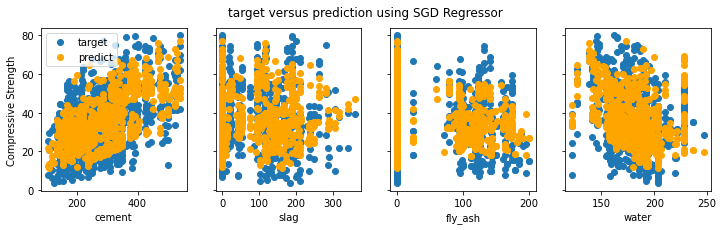

In [103]:
# plot predictions and targets vs original features
X_features = ['cement','slag','fly_ash','water']
X_train_tr = scaler.inverse_transform(X_train)
fig,ax=plt.subplots(1,4,figsize=(12,3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train_tr[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(X_train_tr[:,i],y_pred_linrg,color="orange", label = 'predict')
ax[0].set_ylabel("Compressive Strength"); ax[0].legend();
fig.suptitle("target versus prediction using SGD Regressor")
plt.show()

## Model Comparison between LinearRegression and SGDRegressor

In [108]:
models.sort_values(by="RMSE (Cross Validated)")

,Model,MAE,MSE,r2 Score,RMSE (Cross Validated)
0,SGDRegressor,8.919084,125.551328,0.57915,10.935058
1,LinearRegression,8.896028,125.265338,0.580109,10.935058
